In [ ]:
# Deep Q Learning Algorithm Implementation

In [1]:
import torch
import random
import gym

import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

from torchvision import transforms
from collections import deque

from IPython.display import clear_output
%matplotlib inline

In [2]:
LEARNING_RATE = 0.0001
DISCOUNT = 0.99
EPISODES = 25000
SHOW_EVERY = 300
BATCH_SIZE = 4
REWARD_PTH = 'rewards.npy'
ENV_NAME ='CartPole-v0'
MODEL_PTH = './models/' + ENV_NAME + '.pth'

STARTING_EPSILON = 0.9
END_EPSILON = 0.1
DECAY_RATE = 0.9999
BATCH_SIZE = 64

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
# One hidden layer function approximator
class Actor(nn.Module):

    def __init__(self, starting_epsilon, end_epsilon, decay_rate, batch_size):
        super(Actor, self).__init__()
        self. eps = starting_epsilon
        self.eps_end = end_epsilon
        self.eps_decay = decay_rate
        self.criterion = torch.nn.MSELoss()
        self.batch_size = batch_size       
        self.block = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, ip):
        return self.block(ip)
    
    
    def act(self, ip):
        self.eps = max(self.eps*self.eps_decay, self.eps_end)      # Decay Doubt Batch random acting doubt
        ip   = torch.FloatTensor(ip).unsqueeze(0).to(device)

        if random.random() < self.eps:
            return env.action_space.sample()
        else:
            return self.forward(ip).max(dim=1)[1].item()
        
    def update(self, memory, optimizer, target_net, loss):
        
        if len(memory) < self.batch_size:
            return 0 
        
        states, actions, rewards, next_states, dones = memory.sample(self.batch_size)
        
        states      = (torch.FloatTensor(np.float32(states))).to(device)
        next_states = (torch.FloatTensor(np.float32(next_states))).to(device)
        actions     = (torch.LongTensor(actions)).unsqueeze(1).to(device)
        rewards     = (torch.FloatTensor(rewards)).to(device)
        dones       = (torch.FloatTensor(dones)).to(device)

        q = self.forward(states).gather(1, actions).squeeze(1)
        q_expected = rewards + target_net(next_states).max(dim=1)[0] * (1 - dones)
        
        td_loss = self.criterion(q, q_expected.detach())
        loss += td_loss.item()
        
        optimizer.zero_grad()
        td_loss.backward()
        optimizer.step()
        
        return loss
        
    
# def weights_init(m):
#     classname = m.__class__.__name__
#     if classname.find('Linear') != -1:
#         nn.init.normal_(m.weight, 0, 1)

In [4]:
# One hidden layer function approximator
class Target(nn.Module):

    def __init__(self, starting_epsilon, end_epsilon, decay_rate, batch_size):
        super(Target, self).__init__()
        self. eps = starting_epsilon
        self.eps_end = end_epsilon
        self.eps_decay = decay_rate
        self.criterion = torch.nn.MSELoss()
        self.batch_size = batch_size       
        self.block = nn.Sequential(
            nn.Linear(4, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, ip):
        return self.block(ip)
    
    
    def act(self, ip):
        self.eps = max(self.eps*self.eps_decay, self.eps_end)      # Decay Doubt Batch random acting doubt
        ip   = torch.FloatTensor(ip).unsqueeze(0).to(device)

        if random.random() < self.eps:
            return env.action_space.sample()
        else:
            return self.forward(ip).max(dim=1)[1].item()

In [5]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [7]:
# Instaciate action_value_function class
q_hat = Actor(STARTING_EPSILON, END_EPSILON, DECAY_RATE, BATCH_SIZE)
q_hat_target = Target(STARTING_EPSILON, END_EPSILON, DECAY_RATE, BATCH_SIZE).to(device)
q_hat_target.load_state_dict(q_hat.state_dict())
q_hat.to(device)
q_hat_target.to(device)

memory = ReplayBuffer(10000)

env = gym.make(ENV_NAME)

cart_position, cart_velocity, angle, pole_tip_velocity = env.reset()
print('cart_position: %5.2f | cart_velocity: %5.2f | angle: %5.2f | Pole Tip velocity: %5.2f'%(cart_position, cart_velocity, angle, pole_tip_velocity))
print('observation_space:',env.observation_space.low,'to',env.observation_space.high,'| Number of action values:',env.action_space.n)

cart_position:  0.02 | cart_velocity: -0.00 | angle: -0.05 | Pole Tip velocity: -0.03
observation_space: [-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38] to [4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38] | Number of action values: 2


In [8]:
optimizer = optim.RMSprop(q_hat.parameters(), lr=LEARNING_RATE)
# scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.9)

In [9]:
def plot(episode, avg_loss, eps, eps_rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Episode: %5d | Average Loss: %5.2f | Epsilon: %4.2f | Avg. Reward: %5.2f'%(episode, np.mean(ep_loss[-20:]), eps, np.mean(ep_rewards[-20:])))
    plt.plot(eps_rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(ep_loss)
    plt.show()

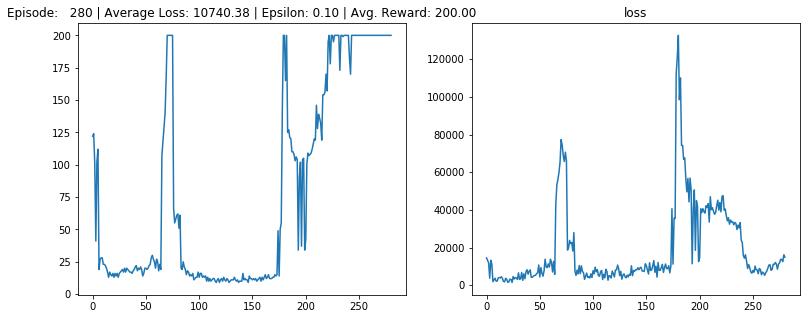

KeyboardInterrupt: 

In [20]:
avg_loss = 0
STEPS = 200
ep_rewards = np.array([])
ep_loss = np.array([])

# Train agent
for episode in range(EPISODES):
    # Episode wise inits
    state = env.reset()
    ep_reward = 0
    running_loss = 0
    done = 0
    
    # Collect Trajectory
    while not done:
        
        action = q_hat.act(state)
        next_state, reward, done, _ = env.step(action)
                    
        ep_reward += reward
        memory.push(state, action, reward, next_state, done)
       
        state = next_state
    
        #Update
        running_loss = q_hat.update(memory, optimizer, q_hat_target, running_loss)
    
    ep_rewards = np.append(ep_rewards, ep_reward)
    ep_loss = np.append(ep_loss, running_loss)
    q_hat_target.load_state_dict(q_hat.state_dict())

    if episode%20 == 0:
        plot(episode, ep_loss, q_hat.eps, ep_rewards)
        avg_loss = 0
        ep_reward = 0
        np.save(REWARD_PTH, ep_rewards)

env.close()

In [ ]:
# Save model
torch.save(q_hat_target.state_dict(),MODEL_PTH)
import torch
q_hat_target = Target(STARTING_EPSILON, END_EPSILON, DECAY_RATE, BATCH_SIZE)
q_hat_target.load_state_dict(torch.load(MODEL_PTH))

In [25]:
# Test your policy
import gym
import time

env = gym.make(ENV_NAME)
# env.reset()
state = env.reset()
done = False
EPS_TEST = 0.05
tot_reward = 0

for step in range(2000):
    state = torch.from_numpy(state).float().to(device)
    env.render()
    action = torch.argmax(q_hat_target(state)).item()
    state, reward, done, _ = env.step(action)
    tot_reward += reward
    if done:
#         print('DONE')
        break
    time.sleep(.002)
    
print('Total Reward:', tot_reward)
    
env.close()

Total Reward: 200.0
